In [1]:
from lime import lime_image
import torch
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [28]:
checkpoint = torch.load('FFPP_model_20_epochs_99acc.pt')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [48]:

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
image = get_image('C:/NCSU Course work/Semester 2/Advanced ML/Phase 2/End Game/Real/10.jpg')

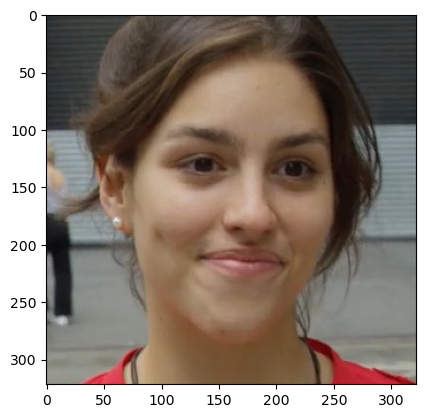

In [49]:
plt.imshow(image)


In [50]:
model.eval()
def predict_fn(image):
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image) 
        output = torch.sigmoid(output)
    return output

In [51]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((128, 128)),

    ])    

    return transf

def get_preprocess_transform(): 
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [52]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.sigmoid(logits)
    return probs.detach().cpu().numpy()
    

In [53]:
test_pred = batch_predict([pill_transf(image)])
test_pred


array([[4.8272395e-06]], dtype=float32)

In [54]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict,
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000,)

  0%|          | 0/1000 [00:00<?, ?it/s]

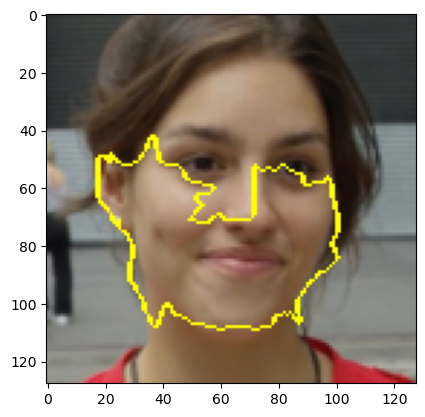

In [55]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5   , hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

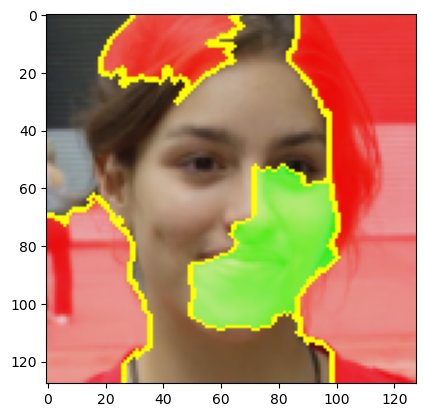

In [64]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=6, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)